In [1]:
import math
from typing import Optional, Tuple, Union

import numpy as np

import gymnasium as gym
from gymnasium import logger, spaces
from gymnasium.envs.classic_control import utils
from gymnasium.error import DependencyNotInstalled


In [ ]:
from os import path
from scipy.optimize import minimize
import d3rlpy
from d3rlpy.dataset import MDPDataset

from d3rlpy.metrics import EnvironmentEvaluator
from sklearn.model_selection import train_test_split

In [ ]:
class CustomCartPoleEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
    }

    def __init__(
        self, render_mode: Optional[str] = None,
        max_ep_len=200,
        force_mag: float = 10.0,
        alpha: float = 0.0,  
        append=False
    ):

        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates
        self.append = append
        self.kinematics_integrator = "euler"

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array(
            [
                self.x_threshold * 2,
                np.inf,
                self.theta_threshold_radians * 2,
                np.inf,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state: np.ndarray | None = None

        self.steps_beyond_terminated = None
        self.max_ep_len = max_ep_len
        self.step_num = 0

        self.alpha = alpha; # prob of random direction force

    def step(self, action):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"
        assert self.state is not None, "Call reset before using step method." 
        x, x_dot, theta, theta_dot = self.state

        # random action start
        executed_action = action
        if self.alpha > 0.0:
         
            if self.np_random.random() < self.alpha:
                executed_action = int(self.np_random.integers(0, 2))

        # random action end
        
        force = self.force_mag if executed_action == 1 else -self.force_mag
        costheta = np.cos(theta)
        sintheta = np.sin(theta)

       
        temp = (
            force + self.polemass_length * np.square(theta_dot) * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length
            * (4.0 / 3.0 - self.masspole * np.square(costheta) / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = np.array((x, x_dot, theta, theta_dot), dtype=np.float64)

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not terminated:
            #reward = 1.0
            reward = abs(2-abs(x/self.x_threshold))*abs(2-abs(theta/self.theta_threshold_radians))-1
        elif self.steps_beyond_terminated is None:
      
            self.steps_beyond_terminated = 0

            reward = abs(2-abs(x/self.x_threshold))*abs(2-abs(theta/self.theta_threshold_radians))-1
            #reward = 0.0
        else:
            # if self.steps_beyond_terminated == 0:
            #     logger.warn(
            #         "You are calling 'step()' even though this environment has already returned terminated = True. "
            #         "You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior."
            #     )
            self.steps_beyond_terminated += 1
            reward = 0.0

        if self.render_mode == "human":
            self.render()

        self.step_num += 1
        if self.step_num >= self.max_ep_len:
            terminated = True
        elif self.append:
            terminated = False

        
        
        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
       
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05  # default low
        )  # default high          
        self.state = self.np_random.uniform(low=low, high=high, size=(4,))
        self.steps_beyond_terminated = None

        self.step_num = 0

        if self.render_mode == "human":
            self.render()
            
        return np.array(self.state, dtype=np.float32), {} 


    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [4]:
def custom_cartpole_random_policy(state):
    return np.random.randint(0, 2)


In [5]:

def data_generation(EnvClass, policy, num_episodes = 100, random_prob = 0):
    
    env = EnvClass(alpha = random_prob)
    states = []
    actions = []
    rewards = []
    terminals = []

    for _ in range(num_episodes):
        obs = env.reset()[0]  # Reset the environment
        done = False

        while not done:
            action = policy(obs)  # Use a random policy
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store the transition
            states.append(obs)
            actions.append(action)
            rewards.append(reward)
            terminals.append(done)

            obs = next_obs  # Update current state

    # Convert to numpy arrays
    states = np.array(states, dtype=np.float32)
    actions = np.array(actions, dtype=np.int32)
    rewards = np.array(rewards, dtype=np.float32)
    terminals = np.array(terminals, dtype=np.bool_)

    dataset = MDPDataset(states, actions, rewards, terminals)
    
    return dataset



def evaluate_policy(policy, EnvClass, gamma=0.95, num_episodes = 100, random_prob = 0):
    print("gamma=", gamma)
    env = EnvClass(alpha = random_prob)
    rewards = []

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        discount = 1.0

        while not done:
            # Select action from the policy
            action = policy.predict(obs.reshape(1,-1)).item()

            # Step in the environment
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Accumulate discounted reward
            episode_reward += discount * reward
            discount *= gamma

            # Update observation
            obs = next_obs

        rewards.append(episode_reward)

    return np.mean(rewards) # Mean and standard deviation of rewards

In [ ]:
def train_sac(MDP_data, env, gamma = 0.95):
    
    sac_beh = d3rlpy.algos.DiscreteSACConfig(gamma=gamma, target_update_interval=1000).create(device="cuda:0")
    sac_beh.build_with_dataset(MDP_data)
    env_evaluator = EnvironmentEvaluator(env)
    sac_beh.fit(MDP_data,
        n_steps=30000,
        n_steps_per_epoch=2000,
        show_progress=False,
        evaluators={
            'environment': env_evaluator,
        },
    )

    return sac_beh



In [ ]:
MDP_data = data_generation(EnvClass = CustomCartPoleEnv, policy = custom_cartpole_random_policy, num_episodes = 500, random_prob = 0)
sac_beh = train_sac(MDP_data, env = CustomCartPoleEnv(), gamma = 0.99)

In [ ]:
sac_beh.save("sac_model.d3")

In [ ]:
returns_sac = []
for kk in [0.0,0.2,0.4,0.6,0.8,1]:
    returns_sac.append(evaluate_policy(sac_beh, EnvClass = CustomCartPoleEnv, gamma=0.95, num_episodes = 500, random_prob = kk))

In [ ]:
import d3rlpy
import gym                 # old gym module
from gym import spaces
from gym.utils import seeding




class CustomCartPoleEnv_gym(gym.Env):
    """
    old gym edition, works for scope-rl
    """

    metadata = {"render.modes": ["human", "rgb_array"]}

    def __init__(
        self,
        max_ep_len: int = 200,
        force_mag: float = 10.0,
        alpha: float = 0.0,
        append: bool = False,
    ):
        super().__init__()

      
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02
        self.kinematics_integrator = "euler"

     
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        high = np.array(
            [
                self.x_threshold * 2,
                np.inf,
                self.theta_threshold_radians * 2,
                np.inf,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

 
        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True

   
        self.state: Optional[np.ndarray] = None
        self.steps_beyond_terminated = None
        self.max_ep_len = int(max_ep_len)
        self.step_num = 0

     
        self.alpha = float(alpha)
        self.append = bool(append)


        self.np_random, _ = seeding.np_random(None)

    def seed(self, seed: Optional[int] = None):
        self.np_random, seed_out = seeding.np_random(seed)
        return [seed_out]

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
    
        if seed is not None:
            self.np_random, _ = seeding.np_random(seed)
    
        
        low, high = -0.05, 0.05
        self.state = self.np_random.uniform(low=low, high=high, size=(4,)).astype(np.float64)
        self.steps_beyond_terminated = None
        self.step_num = 0
    
        if getattr(self, "render_mode", None) == "human":
            self.render()
    
        obs = self.state.astype(np.float32)
        info = {}
        return obs, info



    def step(self, action: int):
        assert self.action_space.contains(action), f"{action!r} invalid"
        assert self.state is not None, "Call reset() before step()."
    
        x, x_dot, theta, theta_dot = self.state
    
  
        executed_action = int(action)
        if self.alpha > 0.0 and self.np_random.random() < self.alpha:
            executed_action = int(self.np_random.integers(0, 2))
    
        force = self.force_mag if executed_action == 1 else -self.force_mag
        costheta, sintheta = np.cos(theta), np.sin(theta)
    
        temp = (force + self.polemass_length * (theta_dot ** 2) * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * (costheta ** 2) / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
    
        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot
    
        self.state = np.array((x, x_dot, theta, theta_dot), dtype=np.float64)
    
        terminated = bool(
            (x < -self.x_threshold)
            or (x > self.x_threshold)
            or (theta < -self.theta_threshold_radians)
            or (theta > self.theta_threshold_radians)
        )
   

        if not terminated:
            reward = abs(2 - abs(x / self.x_threshold)) * abs(2 - abs(theta / self.theta_threshold_radians)) - 1
        elif self.steps_beyond_terminated is None:
            self.steps_beyond_terminated = 0
            reward = abs(2 - abs(x / self.x_threshold)) * abs(2 - abs(theta / self.theta_threshold_radians)) - 1
        else:
            self.steps_beyond_terminated += 1
            reward = 0.0
    
        self.step_num += 1
        truncated = self.step_num >= self.max_ep_len
        if self.append:
         
            truncated = False
            terminated = False
    
        info = {}
        if truncated:
            info["TimeLimit.truncated"] = True
    
        obs = self.state.astype(np.float32)
        return obs, float(reward), bool(terminated), bool(truncated), info

    def render(self, mode="human"):
       
        return None

    def close(self):
        if self.screen is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()
            self.isopen = False


In [34]:

from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import EpsilonGreedyHead
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as OPE
from scope_rl.ope.discrete import TrajectoryWiseImportanceSampling as TIS        
from scope_rl.ope.discrete import PerDecisionImportanceSampling as PDIS 
from scope_rl.ope.discrete import DirectMethod as DM
from scope_rl.ope.discrete import DoublyRobust as DR

In [40]:
cartpole_env_1 = CustomCartPoleEnv_gym()

In [ ]:

behavior_policy = EpsilonGreedyHead(
    sac_beh,
    n_actions=2,
    epsilon=0.3,
    name="sac_beh",
    random_state=12345,
)


In [ ]:
sac_policy = EpsilonGreedyHead(
    sac_beh,
    n_actions=2,
    epsilon=0.0,
    name="sac_beh",
    random_state=12345,
)


In [ ]:
d3rlpy.seed(2)
np.random.seed(2)
kkk = 10
ope_result = np.zeros((kkk, 3))

for i in range(kkk):
    # initialize dataset class
    dataset = SyntheticDataset(
        env=cartpole_env_1,
        max_episode_steps=200,
    )
    
    # data collection
    logged_dataset = dataset.obtain_episodes(
        behavior_policies=behavior_policy,
        n_trajectories=300,
        random_state=i,
    )
    
    prep = CreateOPEInput(
        env=cartpole_env_1,
        gamma=0.95,
    )
    input_dict = prep.obtain_whole_inputs(
        logged_dataset=logged_dataset,
        evaluation_policies=[sac_policy],
        require_value_prediction=True,
        n_steps=20000,
        n_trajectories_on_policy_evaluation=100,
        random_state=i*20,
    )
    
    ope = OPE(
        logged_dataset=logged_dataset,
        ope_estimators=[DM(), DR(),PDIS()],
    )
    policy_value_dict = ope.estimate_policy_value(
        input_dict=input_dict,
    )

    ope_result[i,0] = policy_value_dict["sac_beh"]["dm"]
    ope_result[i,1] = policy_value_dict["sac_beh"]["dr"]
    ope_result[i,2] = policy_value_dict["sac_beh"]["pdis"]



In [ ]:
np.savetxt("cartpole_ope_result.csv", ope_result, delimiter=",")

In [ ]:
import pandas as pd

df = pd.read_csv("tv_result_greedy.csv")
tv_result_greedy = df.to_numpy(dtype=float)


In [ ]:

df = pd.read_csv("wass_result_greedy.csv")

wass_result_greedy = df.to_numpy(dtype=float)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_ope_summary(wass_result, tv_result, ope_result, true_vals, show=True):
    x   = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0], dtype=float)
    z   = 1.96
    eps = 0.04

    def mean_ci(arr_2d):
        m = np.mean(arr_2d, axis=0)
        s = np.std(arr_2d, axis=0, ddof=1)
        n = arr_2d.shape[0]
        half = z * s / np.sqrt(n)
        return m, m - half, m + half

    def mean_ci_singlecol(col_1d, repeat_len=6):
        m = float(np.mean(col_1d)); s = float(np.std(col_1d, ddof=1)); n = len(col_1d)
        half = z * s / np.sqrt(n)
        return np.full(repeat_len, m), np.full(repeat_len, m-half), np.full(repeat_len, m+half)

    wass_mean, wass_lo, wass_hi = mean_ci(wass_result)
    tv_mean,   tv_lo,   tv_hi   = mean_ci(tv_result)
    dm_mean,   dm_lo,   dm_hi   = mean_ci_singlecol(ope_result[:, 0])
    dr_mean,   dr_lo,   dr_hi   = mean_ci_singlecol(ope_result[:, 1])
    pdis_mean, pdis_lo, pdis_hi = mean_ci_singlecol(ope_result[:, 2])

    fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')

    ax.fill_between(x, wass_lo, wass_hi, alpha=0.2, color="skyblue")
    ax.plot(x, wass_mean, marker="o", color="steelblue", label="Wass Method")

    ax.fill_between(x, tv_lo, tv_hi, alpha=0.2, color="orange")
    ax.plot(x, tv_mean, marker="o", color="darkorange", label="TV Method")

    ax.fill_between(x, dm_lo, dm_hi, alpha=0.2, color="lightgreen")
    ax.plot(x, dm_mean, marker="o", color="green", label="DM")

    ax.fill_between(x, dr_lo, dr_hi, alpha=0.2, color="plum")
    ax.plot(x, dr_mean, marker="o", color="purple", label="DR")

    #ax.fill_between(x, pdis_lo, pdis_hi, alpha=0.2, color="thistle")
    #ax.plot(x, pdis_mean, marker="o", color="indigo", label="PDIS")


    ax.plot(x, true_vals, marker="o", color="red", linewidth=2, label="true value")

    ax.set_xlabel("Probability of Random Actions")
    ax.set_ylabel("value")
    #ax.set_title("Robust OPE with Different Probability of Random Actions")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)

    if show:
        plt.show()
    return fig, ax

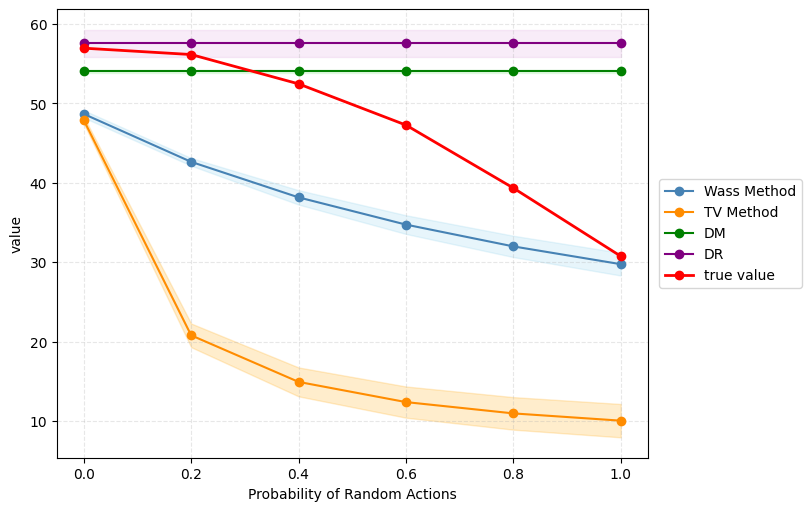

In [ ]:
fig, ax = plot_ope_summary(wass_result= wass_result_greedy,
                     tv_result = tv_result_greedy,
                     ope_result = ope_result,   
                     true_vals = returns_sac)

In [ ]:
fig.savefig("ope_plot_cartpole.png", dpi=300, bbox_inches="tight")